In [1]:
import pandas as pd

errorlogs = pd.read_pickle('errlogs.pkl')
# found thanks to clustering! 
suspicious_cids = [70715, 70716, 74459, 74460, 74461, 74463, 74464]
for cid in suspicious_cids:
    errorlogs = errorlogs[errorlogs.cid != cid]


In [2]:
len(errorlogs)

3531

In [3]:
errorlogs.loc[3]['error_message']

'make[4]: flex: Command not found\nmake[4]: *** [/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_scan.c] Error 127\nmake[3]: *** [drivers/scsi/aic7xxx/aicasm/aicasm] Error 2\nmake[2]: *** [drivers/scsi/aic7xxx] Error 2\nmake[1]: *** [drivers/scsi] Error 2\nmake[1]: *** Waiting for unfinished jobs....\nmake: *** [drivers] Error 2\n'

In [4]:
from enum import Enum, auto
class ErrorLog(Enum):
    BLACKLIGHT = auto(),
    BLACKLIGHT2 = auto(),
    CONFIG_NLS_DEFAULT = auto(),
    CRC32_CLUSTER = auto(),
    V4L2 = auto(), 
    OVERFLOW2 = auto(), 
    ULPI = auto(), 
    PCM = auto(),
    TTM = auto(), 
    AS68K = auto(), 
    GEN = auto(), 
    AICDB = auto(), 
    AIC7XXX = auto(),
    DRM_BRIDGE_CLUSTER = auto(),
    PINCTRL_CLUSTER = auto(), 
    BTBCM = auto(),
    BPFFANCY = auto(), 
    DEVM = auto(), 
    DEVM2 = auto(), 
    I2C_CLUSTER = auto() 
    


    

patterns = { ErrorLog.BLACKLIGHT : "undefined reference to `backlight_device",
            ErrorLog.BLACKLIGHT2: 'error: ‘intel_backlight_device_register’', # 'intel_backlight_device_register', # cid 87044 does not match BACKLIGHT 
            ErrorLog.CONFIG_NLS_DEFAULT : "CONFIG_NLS_DEFAULT",
            ErrorLog.CRC32_CLUSTER : 'undefined reference to `crc32', 
            ErrorLog.V4L2 : 'undefined reference to `v4l2',
            ErrorLog.OVERFLOW2 : '__read_overflow2',
            ErrorLog.ULPI : 'undefined reference to `ulpi', # 100-126K dataset
            ErrorLog.PCM : 'undefined reference to `atmel_pcm_dma_platform', # 100-126K dataset
            ErrorLog.TTM : 'undefined reference to `ttm', 
            ErrorLog.AS68K: 'as68k: not found',
            ErrorLog.GEN : 'undefined reference to `gen_pool', 
            ErrorLog.AIC7XXX: '[drivers/scsi/aic7xxx/aicasm/aicasm] Error 2', #'drivers/scsi/aic7xxx',
            ErrorLog.AICDB : 'aicdb.h: No such file or directory', 
            ErrorLog.DRM_BRIDGE_CLUSTER : 'undefined reference to `drm_panel_bridge_add', 
            ErrorLog.PINCTRL_CLUSTER : '[drivers/pinctrl/pinctrl-mcp23s08.o] Error', #'pinctrl-mcp23s08', # loosely pattern (too general?)
            ErrorLog.BTBCM : 'undefined reference to `btbcm_set_bdaddr', 
            ErrorLog.BPFFANCY : 'bpf-fancy', # loosely pattern (too general?)
            ErrorLog.DEVM : 'undefined reference to `__devm_regmap',
            ErrorLog.I2C_CLUSTER: 'error: implicit declaration of function ‘i2c_get_adapter’', #'i2c_get_adapter',
            ErrorLog.DEVM2 : 'undefined reference to `devm_of_led'
           }

pattern_name = [name for name, member in ErrorLog.__members__.items()]
# TODO: instead of having True/False values for each pattern column name, 
# let's have a single column with cluster(s) values
error_pattern = pd.DataFrame(columns=pattern_name, index=errorlogs['cid'])
error_pattern.fillna(False, inplace=True)

for i, errorlog in errorlogs.iterrows():
    error = errorlog['error_message']
    cid = errorlog['cid']
    for k, p in patterns.items():
        if (p in error):
            error_pattern.loc[cid][k.name] = True
            # TODO: error_pattern.loc[cid]['cluster_error'] = k.name
            #print (k.name, "found in configuration", cid)
            
            
            


In [5]:
# same, except we use the first error message (and only it)
# it mimics basic Linux build process
# see discussion here: https://github.com/TuxML/compilation-analysis/issues/1#issuecomment-488711237

pattern_name = [name for name, member in ErrorLog.__members__.items()]
error_patternfirst = pd.DataFrame(columns=pattern_name, index=errorlogs['cid'])
error_patternfirst.fillna(False, inplace=True)

for i, errorlog in errorlogs.iterrows():
    error = errorlog['error_message']
    cid = errorlog['cid']
    #print(cid)
    for err in error.splitlines():
        found = False
        for k, p in patterns.items():
            if found:
                break
            if (p in err):
                error_patternfirst.loc[cid][k.name] = True
                found = True
                #print (k, "found")
        if found:
            break
    #for k, p in patterns.items():
    #    if (p in error):
    #        error_patternfirst.loc[cid][k.name] = True
            #print (k.name, "found in configuration", cid)

In [6]:
error_patternfirst

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,GEN,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER
cid,,,,,,,,,,,,,,,,,,,,
30699,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
30700,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
30704,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
30717,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
30718,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
30722,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
30726,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
30730,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
30731,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False


In [7]:
#error_pattern.loc[99949]['BLACKLIGHT'] = True
error_pattern['CONFIG_NLS_DEFAULT'].value_counts()
#error_pattern.hist()

False    3526
True        5
Name: CONFIG_NLS_DEFAULT, dtype: int64

BLACKLIGHT              10
BLACKLIGHT2              1
CONFIG_NLS_DEFAULT       5
CRC32_CLUSTER            2
V4L2                     9
OVERFLOW2               86
ULPI                     0
PCM                      0
TTM                     11
AS68K                  550
GEN                    279
AICDB                 2514
AIC7XXX               2681
DRM_BRIDGE_CLUSTER       3
PINCTRL_CLUSTER          3
BTBCM                    2
BPFFANCY                 2
DEVM                     2
DEVM2                    1
I2C_CLUSTER              1
dtype: int64

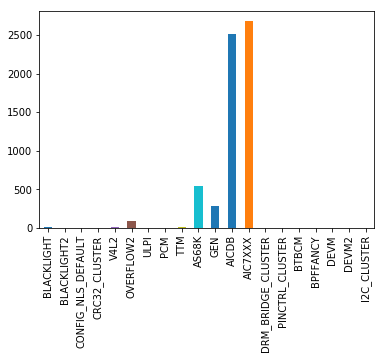

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline  

def nb_patterns(row):
    return sum(row == True)                    
error_pattern['nb_patterns'] = error_pattern.apply(nb_patterns, axis=1)
pattern_frequencies = error_pattern[pattern_name].apply(nb_patterns, axis=0)
pattern_frequencies.plot(kind='bar')
pattern_frequencies

BLACKLIGHT              10
BLACKLIGHT2              1
CONFIG_NLS_DEFAULT       5
CRC32_CLUSTER            2
V4L2                     9
OVERFLOW2               86
ULPI                     0
PCM                      0
TTM                     11
AS68K                  478
GEN                    277
AICDB                 2476
AIC7XXX                162
DRM_BRIDGE_CLUSTER       3
PINCTRL_CLUSTER          3
BTBCM                    2
BPFFANCY                 2
DEVM                     2
DEVM2                    1
I2C_CLUSTER              1
dtype: int64

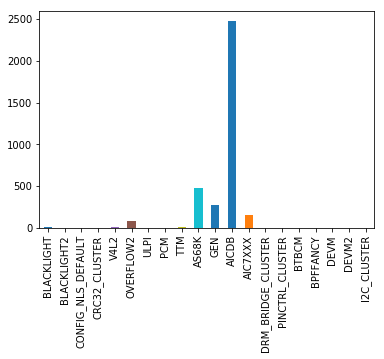

In [9]:
import numpy as np 
# error_patternfirst['nb_patterns'] = error_patternfirst.apply(nb_patterns, axis=1)
patternfirst_frequencies = error_patternfirst[pattern_name].apply(nb_patterns, axis=0)
patternfirst_frequencies.plot(kind='bar')
patternfirst_frequencies
# np.unique(error_patternfirst['nb_patterns'].values)

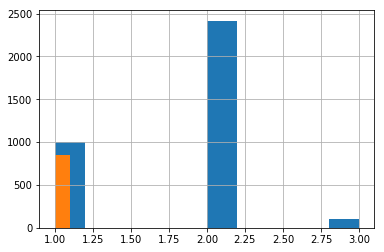

In [10]:
error_pattern['nb_patterns'].hist()
error_pattern.query("AIC7XXX == False")['nb_patterns'].hist()

In [11]:
error_pattern.sort_values(by='nb_patterns', ascending=False)[:20]

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
68566,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
59360,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
57646,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
51532,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
79222,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
46328,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
37984,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
44012,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3
72724,False,False,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,False,3


In [12]:
#error_pattern['CONFIG_NLS_DEFAULT'].value_counts().plot(kind='bar')
error_pattern.query('nb_patterns == 0')

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,


In [13]:
error_pattern.query('nb_patterns == 0').shape

(0, 21)

In [14]:
for cid in error_pattern.query('nb_patterns == 0').index:
    print ("configuration cid", cid)
    #if cid in suspicious_cids:
    #    print("false positive failure")
    #    continue
    
    error_message = errorlogs.query("cid == " + str(cid))['error_message'].values
    for err in error_message[0].splitlines():
        if "Cyclomatic" not in err:
            print (err)
    print()
    print()
    print()
    
# 74459, 74460, 74461, 74463, 74464

In [15]:
error_pattern.query('nb_patterns >= 2 & (AS68K == True & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)



,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,


In [16]:
error_pattern.query('nb_patterns >= 2 & (AS68K == False & AIC7XXX == False & AICDB == True)').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,


In [17]:
#error_pattern.query('nb_patterns == 2 & (as68k == False & AIC7XXX == True)').sort_values(by='nb_patterns', ascending=False)
error_pattern.query('nb_patterns >= 2 & (AS68K == False & AICDB == False & AIC7XXX == True)').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,


In [18]:
error_pattern.query('nb_patterns >= 2 & (AS68K == False & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
60939,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2
78770,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2


In [19]:
# masking effect
error_pattern.query('nb_patterns >= 2 & CONFIG_NLS_DEFAULT == True').sort_values(by='nb_patterns', ascending=False)
error_pattern.query('CONFIG_NLS_DEFAULT == True').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
44596,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
52277,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
60391,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
62743,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
99949,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [20]:
# masking effect
error_pattern.query('GEN == True').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
78770,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2
60939,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,2
30821,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
79950,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
79434,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
79281,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
78932,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
78821,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
78740,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [21]:
error_pattern.query('BLACKLIGHT == True').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
59503,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
64086,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
65670,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
66938,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
67750,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
75145,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
81720,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
89618,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
93674,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [22]:
# nice masking effect!
error_pattern.query('PINCTRL_CLUSTER == True & (AS68K == False & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
37227,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1
89854,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1
98605,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,1


In [23]:
# nice masking effect!
error_pattern.query('I2C_CLUSTER == True & (PINCTRL_CLUSTER == False & AS68K == False & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
96730,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,1


In [24]:
import json
# see Hugo notebook here!
with open("option_columns.json","r") as f:
    option_columns = json.load(f)


In [25]:
rawtuxdata = pd.read_csv("dataset_after_encoding.csv", dtype={k:"int8" for k in option_columns})
rawtuxdata.info(memory_usage='deep')
rawtuxdata.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69362 entries, 0 to 69361
Columns: 12654 entries, X86_LOCAL_APIC to cid
dtypes: float64(6), int64(37), int8(12611)
memory usage: 857.0 MB


(69362, 12654)

In [26]:
set(errorlogs['cid']) - set(rawtuxdata['cid'])

{30699,
 33833,
 33836,
 33837,
 54125,
 54126,
 54127,
 54128,
 54129,
 56432,
 56558,
 57249,
 70614,
 70665,
 70709,
 70710,
 74227,
 74233,
 78892,
 79033,
 79141,
 88152,
 88817,
 88909}

In [27]:
basic_head = ["cid", "time", "date"] # "compile"
compilation_status_column_name = 'compile_success'
size_methods = ["vmlinux", "GZIP-bzImage", "GZIP-vmlinux", "GZIP", "BZIP2-bzImage", 
              "BZIP2-vmlinux", "BZIP2", "LZMA-bzImage", "LZMA-vmlinux", "LZMA", "XZ-bzImage", "XZ-vmlinux", "XZ", 
              "LZO-bzImage", "LZO-vmlinux", "LZO", "LZ4-bzImage", "LZ4-vmlinux", "LZ4"]

In [28]:
print(str(len(rawtuxdata)) + " before the removal of some entries (those with same configurations)")
# tuxdata.drop_duplicates(subset=tuxdata.columns.difference(['vmlinux']), inplace=True)
rawtuxdata.drop_duplicates(subset=rawtuxdata.columns.difference(size_methods).difference(basic_head), inplace=True)
print(str(len(rawtuxdata)) + " after the removal of some entries (those with same configurations)")

69362 before the removal of some entries (those with same configurations)
69362 after the removal of some entries (those with same configurations)


In [29]:
cid_errors_not_in_configdata = set(errorlogs['cid']) - set(rawtuxdata['cid'])
for cid in cid_errors_not_in_configdata:
    error_message = errorlogs.query("cid == " + str(cid))['error_message'].values
    for err in error_message[0].splitlines():
        if "Cyclomatic" not in err:
            print (err)
    

aicasm_symbol.c:48:19: fatal error: aicdb.h: No such file or directory
 #include "aicdb.h"
                   ^
compilation terminated.
aicasm_gram.tab.c: In function 'yyparse':
aicasm_gram.tab.c:1628:16: warning: implicit declaration of function 'yylex' [-Wimplicit-function-declaration]
aicasm_macro_gram.tab.c: In function 'mmparse':
/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_macro_gram.c:64:25: warning: implicit declaration of function 'mmlex' [-Wimplicit-function-declaration]
 #define yylex           mmlex
                         ^
aicasm_macro_gram.tab.c:1199:16: note: in expansion of macro 'yylex'
aicasm_scan.l: In function 'yylex':
aicasm_scan.l:420:6: warning: implicit declaration of function 'mm_switch_to_buffer' [-Wimplicit-function-declaration]
      yy_switch_to_buffer(temp_state);
      ^~~~~~~~~~~~~~~~~~~
aicasm_scan.l:421:6: warning: implicit declaration of function 'mmparse' [-Wimplicit-function-declaration]
      mm_switch_to_buffer(old_state);
      ^~~~~

In file included from ./include/linux/bitmap.h:8:0,
                 from ./include/linux/cpumask.h:11,
                 from ./arch/x86/include/asm/cpumask.h:4,
                 from ./arch/x86/include/asm/msr.h:10,
                 from ./arch/x86/include/asm/processor.h:20,
                 from ./arch/x86/include/asm/cpufeature.h:4,
                 from ./arch/x86/include/asm/thread_info.h:52,
                 from ./include/linux/thread_info.h:37,
                 from ./arch/x86/include/asm/preempt.h:6,
                 from ./include/linux/preempt.h:80,
                 from ./include/linux/spinlock.h:50,
                 from drivers/infiniband/core/core_priv.h:37,
                 from drivers/infiniband/core/roce_gid_mgmt.c:33:
In function 'memcpy',
    inlined from 'rdma_ip2gid' at ./include/rdma/ib_addr.h:175:3,
    inlined from 'addr_event.isra.0.constprop' at drivers/infiniband/core/roce_gid_mgmt.c:691:2,
    inlined from 'inetaddr_event' at drivers/infiniband/core/roce_

In [30]:
# TODO: workaround 
# see issue here: https://github.com/TuxML/compilation-analysis/issues/7
for cid in cid_errors_not_in_configdata:
    errorlogs = errorlogs[errorlogs.cid != cid]
    error_patternfirst = error_patternfirst[error_patternfirst.index != cid]
    error_pattern = error_pattern[error_pattern.index != cid]

errorlogs.shape, error_patternfirst.shape, error_pattern.shape

((3507, 2), (3507, 20), (3507, 21))

BLACKLIGHT              10
BLACKLIGHT2              1
CONFIG_NLS_DEFAULT       5
CRC32_CLUSTER            2
V4L2                     9
OVERFLOW2               83
ULPI                     0
PCM                      0
TTM                     11
AS68K                  474
GEN                    275
AICDB                 2464
AIC7XXX                161
DRM_BRIDGE_CLUSTER       3
PINCTRL_CLUSTER          3
BTBCM                    2
BPFFANCY                 0
DEVM                     2
DEVM2                    1
I2C_CLUSTER              1
dtype: int64

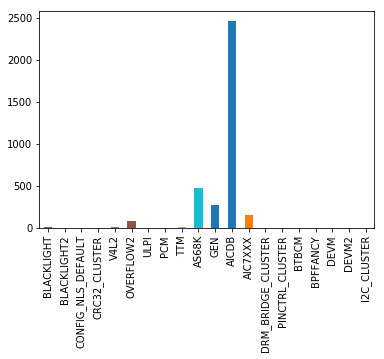

In [31]:
patternfirst_frequencies = error_patternfirst[pattern_name].apply(nb_patterns, axis=0)
patternfirst_frequencies.plot(kind='bar')
patternfirst_frequencies

In [32]:
from sklearn.model_selection import train_test_split
from sklearn import tree


TESTING_SIZE= 0.001 #0.99 # 0.001 # 0.9
X_train, X_test, y_train, y_test = train_test_split(
    rawtuxdata
    .drop(columns=["cid"])
    .drop(columns=size_methods)
    .drop(columns=compilation_status_column_name), 
    rawtuxdata[compilation_status_column_name], test_size=TESTING_SIZE, random_state=0)  
clf = tree.DecisionTreeClassifier() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [33]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score

y_pred = clf.predict(X_test)

acc = accuracy_score (y_test, y_pred)
prec = precision_score (y_test, y_pred)
reca = recall_score (y_test, y_pred)
f1 = f1_score (y_test, y_pred)
balance_acc = balanced_accuracy_score (y_test, y_pred)
print("Accuracy score:", acc)
print("Precision score:", prec)
print("Recall score:", reca)
print("F1 score:", f1)
print("Balance accuracy score:", balance_acc)

Accuracy score: 1.0
Precision score: 1.0
Recall score: 1.0
F1 score: 1.0
Balance accuracy score: 1.0


In [34]:
del X_train
del X_test 
del y_train 
del y_test

In [35]:
import graphviz 

def printTree(clf, feature_names):
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=feature_names,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render("TUXML_compilation_failures")
    
printTree(clf, rawtuxdata.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=compilation_status_column_name).columns)

In [36]:
from sklearn.tree import _tree

def tree_to_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, previous_rules):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            #print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], previous_rules+[name + " <= " + str(threshold)])
            #print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], previous_rules+[name + " > " + str(threshold)])
        else:
            print(" & ".join(previous_rules) + " ---> " + str(tree_.value[node]))

    recurse(0, [])
    
tree_to_rules(clf, rawtuxdata.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=compilation_status_column_name).columns)

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR <= 0.5 & DRM_VBOXVIDEO <= 1.5 & MLX5_INFINIBAND <= 0.5 & INTERVAL_TREE_TEST <= 1.0 ---> [[1. 0.]]
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR <= 0.5 & DRM_VBOXVIDEO <= 1.5 & MLX5_INFINIBAND <= 0.5 & INTERVAL_TREE_TEST > 1.0 ---> [[0. 1.]]
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR <= 0.5 & DRM_VBOXVIDEO <= 1.5 & MLX5_INFINIBAND > 0.5 & ISDN_DIVAS_USERIDI <= 0.5 & INPUT_SPARSEKMAP <= 1.5 ---> [[0. 3.]]
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR <= 0.5 & DRM_VBOXVIDEO <= 1.5 & MLX5_INFINIBAND > 0.5 & ISDN_DIVAS_USERIDI <= 0.5 & INPUT_SPARSEKMAP > 1.5 ---> [[1. 0.]]
AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR 

In [37]:
def tree_to_failure_rules(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print ("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, previous_rules, acc):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            #print ("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], previous_rules+[name + " <= " + str(threshold)], acc)
            #print ("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], previous_rules+[name + " > " + str(threshold)], acc)
        else:
            if tree_.value[node][0][0] > tree_.value[node][0][1]:
                #print(" & ".join(previous_rules) + " ---> " + str(tree_.value[node]))
                acc.append(" & ".join(previous_rules))

    acc = []
    recurse(0, [], acc)
    return acc
    
all_paths = tree_to_failure_rules(clf, rawtuxdata.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=compilation_status_column_name).columns)

In [38]:

    
def find_rule_for_configuration(tree, feature_names, configuration):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    
    def recurse(node, previous_rules, configuration):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            #print ("{}if {} <= {}:".format(indent, name, threshold))
            if configuration[name] <= threshold:
                return recurse(tree_.children_left[node], previous_rules+[name + " <= " + str(threshold)], configuration)
            #print ("{}else:  # if {} > {}".format(indent, name, threshold))
            else:
                return recurse(tree_.children_right[node], previous_rules+[name + " > " + str(threshold)], configuration)
        else:
            #if tree_.value[node][0][0] > tree_.value[node][0][1]:
            #print(" & ".join(previous_rules))
            return " & ".join(previous_rules)
       
    return recurse(0, [], configuration)
    
def find_rule_for_configuration_id(cid):
    return find_rule_for_configuration(clf, rawtuxdata.drop(columns=["cid"]).drop(columns=size_methods).drop(columns=compilation_status_column_name).columns, rawtuxdata.query("cid == " + str(cid)).iloc[0]) 

find_rule_for_configuration_id(92072)

'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS <= 0.5 & SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH <= 1.5 & SND_PDAUDIOCF <= 1.5 & TYPEC_WCOVE <= 1.5 & CAN_GS_USB <= 1.5 & SND_ATMEL_SOC > 1.5 & PCCARD <= 0.5'

In [39]:
rawtuxdata.query("AIC7XXX_BUILD_FIRMWARE == 1 | AIC79XX_BUILD_FIRMWARE == 1 | WANXL_BUILD_FIRMWARE == 1").shape

(3106, 12654)

In [40]:
rawtuxdata.query("(AIC7XXX_BUILD_FIRMWARE == 0 & AIC79XX_BUILD_FIRMWARE == 0) & WANXL_BUILD_FIRMWARE == 1")['compile_success'].unique()

array([0])

In [41]:
rawtuxdata.query("AIC7XXX_BUILD_FIRMWARE == 0 & AIC79XX_BUILD_FIRMWARE == 0 & WANXL_BUILD_FIRMWARE == 0 & compile_success == False").shape

(401, 12654)

In [42]:
'''
basic conclusion: bug GENERIC_ALLOCATOR + DRM_VBOXVIDEO is always masked by firmwares-like failures
'''
generic_allocator_mask_firmwares = rawtuxdata.query("GENERIC_ALLOCATOR == 0 & DRM_VBOXVIDEO == 2 & (AIC7XXX_BUILD_FIRMWARE == 1 | AIC79XX_BUILD_FIRMWARE == 1 | WANXL_BUILD_FIRMWARE == 1)  & compile_success == False")
print("generic allocator bug with firmwares' failures", generic_allocator_mask_firmwares.shape)
print()
print()
for cid in generic_allocator_mask_firmwares['cid']:
    print ("###### configuration id", cid)
    err_pattern = error_pattern.query("cid == " + str(cid)).iloc[0]
    for err in ErrorLog:
        if (err_pattern[err.name]):
            print(err)
    error_messages = errorlogs.query("cid == " + str(cid)).iloc[0]['error_message'].splitlines()
    for error in error_messages:
        if "Cyclomatic " not in error:
            print(error)
    print()
    print()




generic allocator bug with firmwares' failures (13, 12654)


###### configuration id 30901
ErrorLog.AIC7XXX
make[4]: flex: Command not found
make[4]: *** [/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_scan.c] Error 127
make[3]: *** [drivers/scsi/aic7xxx/aicasm/aicasm] Error 2
make[2]: *** [drivers/scsi/aic7xxx] Error 2
make[1]: *** [drivers/scsi] Error 2
make[1]: *** Waiting for unfinished jobs....
make: *** [drivers] Error 2


###### configuration id 36364
ErrorLog.AS68K
In file included from ./include/linux/uaccess.h:13:0,
                 from ./include/linux/highmem.h:8,
                 from fs/binfmt_elf.c:28:
fs/binfmt_elf.c: In function 'create_elf_tables':
./arch/x86/include/asm/uaccess_64.h:143:20: warning: array subscript is above array bounds [-Warray-bounds]
    __put_user_asm(4[(u16 *)src], 4 + (u16 __user *)dst,
                    ^
./arch/x86/include/asm/uaccess.h:468:16: note: in definition of macro '__put_user_asm'
        : ltype(x), "m" (__m(addr)), "i" (

drivers/gpu/drm/radeon/radeon_object.c: In function 'radeon_bo_create':
drivers/gpu/drm/radeon/radeon_object.c:242:2: warning: #warning Please enable CONFIG_MTRR and CONFIG_X86_PAT for better performance thanks to write-combining [-Wcpp]
 #warning Please enable CONFIG_MTRR and CONFIG_X86_PAT for better performance \
  ^~~~~~~
aicasm_symbol.c:48:19: fatal error: aicdb.h: No such file or directory
 #include "aicdb.h"
                   ^
compilation terminated.
aicasm_gram.tab.c: In function 'yyparse':
aicasm_gram.tab.c:1628:16: warning: implicit declaration of function 'yylex' [-Wimplicit-function-declaration]
aicasm_macro_gram.tab.c: In function 'mmparse':
/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_macro_gram.c:64:25: warning: implicit declaration of function 'mmlex' [-Wimplicit-function-declaration]
 #define yylex           mmlex
                         ^
aicasm_macro_gram.tab.c:1199:16: note: in expansion of macro 'yylex'
aicasm_scan.l: In function 'yylex':
aicasm_scan.

In [43]:
'''
basic conclusion: bug GENERIC_ALLOCATOR + DRM_VBOXVIDEO is not masked by other failures
but may mask other failures 
'''

generic_allocator_mask_notfirmware = rawtuxdata.query("GENERIC_ALLOCATOR == 0 & DRM_VBOXVIDEO == 2 & ~(AIC7XXX_BUILD_FIRMWARE == 1 | AIC79XX_BUILD_FIRMWARE == 1 | WANXL_BUILD_FIRMWARE == 1)  & compile_success == False")


print("generic allocator bug *without* firmwares' failures", generic_allocator_mask_notfirmware.shape)
print()
print()
for cid in generic_allocator_mask_notfirmware['cid']:
    err_pattern = error_pattern.query("cid == " + str(cid)).iloc[0]
    if not (err_pattern[ErrorLog.GEN.name]):
        print ("###### configuration id", cid)
        print("GENERIC allocator NOT found")
    #else:
    #    for err in ErrorLog:
    #        if (err_pattern[err.name]):
    #            print(err)
   

generic allocator bug *without* firmwares' failures (277, 12654)




In [44]:
# ~(AIC7XXX_BUILD_FIRMWARE == 1 | AIC79XX_BUILD_FIRMWARE == 1 | WANXL_BUILD_FIRMWARE == 1)  &
# Mathieu: I'm deactivating it, it's time-consuming and error-prone 
if False:
    for path1 in all_paths[::-1]:
        # collect all cids related to a path
        path_cids = rawtuxdata.query(path1 + " & compile_success == False")['cid'].values
        spath_cids = set(path_cids)
        print (path1)
        for path2 in all_paths[::-1]:
            if (path1 != path2):                
                for cid in path_cids:
                    # report whether an alternate path/rule can match the cid 
                    #print (cid)
                    overlap = rawtuxdata.query(path2 + " & compile_success == False & cid == " + str(cid)) #['cid'].values
                    #overlap = list(spath_cids & set(path_cids2)) 
                    if len(overlap) > 0:
                        print(path1, "also hold with\n", path2, "=> #", overlap)
                        print()
    
       
#    for path2 in all_paths:
#        if (path1 != path2):
#            overlap = len(rawtuxdata.query(path1 + " | ~(" + path2 + ") & compile_success == False").index)
#            if  overlap > 0:
#                print(path1, "also hold with\n", path2, "=> #", overlap)
#                print()
        
        
#

In [45]:
# TODO: classification on clusters!
rawtuxdata = pd.merge(rawtuxdata, error_patternfirst, on='cid', how='outer')

In [46]:
rawtuxdata.shape, error_patternfirst.shape

((69362, 12674), (3507, 20))

In [47]:
rawtuxdata.query(ErrorLog.AICDB.name + " == True").shape
# rawtuxdata['cid']
# configwithclusters['cid']

(2464, 12674)

In [48]:
for err in ErrorLog:
    rawtuxdata[err.name] = rawtuxdata[err.name].fillna(False)

In [49]:
'''
create a column with the first kind/cluster of error message that pops out
it will be a label
allows multi-class classification (instead of simply binary classification)
TODO: applies to error_patternfirst and error_pattern
'''

from sklearn.preprocessing import LabelEncoder
# FIXE: enum auto() does not work
def which_pattern(row):
    for err in ErrorLog:
        if (row[err.name]):
            return err.name
    return "NO_FAILURE"
cluster_errorfirst = rawtuxdata.apply(which_pattern, axis=1)
cluster_errorfirst.unique()


array(['NO_FAILURE', 'AS68K', 'AIC7XXX', 'OVERFLOW2', 'GEN', 'V4L2',
       'DRM_BRIDGE_CLUSTER', 'AICDB', 'PINCTRL_CLUSTER',
       'CONFIG_NLS_DEFAULT', 'TTM', 'CRC32_CLUSTER', 'BTBCM',
       'BLACKLIGHT', 'DEVM2', 'DEVM', 'BLACKLIGHT2', 'I2C_CLUSTER'],
      dtype=object)

In [50]:

# encoding strings as labels
le_cluster = LabelEncoder()
rawtuxdata['cluster_errorfirst'] = le_cluster.fit_transform(cluster_errorfirst)

In [85]:
from sklearn.model_selection import train_test_split
from sklearn import tree

TESTING_SIZE_CLUSTER= 0.1 #0.99 # 0.001 # 0.9
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(
    rawtuxdata
    .drop(columns=["cid"])
    .drop(columns=['cluster_errorfirst'])
   # .drop(columns=["nb_patterns"])
    .drop(columns=pattern_name)
    .drop(columns=size_methods)
    .drop(columns=compilation_status_column_name), 
    rawtuxdata['cluster_errorfirst'], test_size=TESTING_SIZE_CLUSTER, random_state=0)  

# rawtuxdata[[ErrorLog.AS68K.name, ErrorLog.AICDB.name]] # multi-output
# rawtuxdata[pattern_name]

clf_cluster = tree.DecisionTreeClassifier() #GradientBoostingClassifier(n_estimators=100) #RandomForestRegressor(n_estimators=100) #   #GradientBoostingRegressor(n_estimators=100)  
clf_cluster.fit(X_train_cluster, y_train_cluster)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [86]:
from sklearn.metrics import matthews_corrcoef

y_pred_cluster = clf_cluster.predict(X_test_cluster)

average_method_cl = 'micro'

acc_cl = accuracy_score (y_test_cluster, y_pred_cluster)
prec_cl = precision_score (y_test_cluster, y_pred_cluster, average=average_method_cl)
reca_cl = recall_score (y_test_cluster, y_pred_cluster, average=average_method_cl)
f1_cl = f1_score (y_test_cluster, y_pred_cluster, average=average_method_cl)
balance_acc_cl = balanced_accuracy_score (y_test_cluster, y_pred_cluster)

matt_cl = matthews_corrcoef(y_test_cluster, y_pred_cluster) 


print("Accuracy score:", acc_cl)
print("Precision score:", prec_cl)
print("Recall score:", reca_cl)
print("F1 score:", f1_cl)
print("Balance accuracy score:", balance_acc_cl)

print("Matthews corr score:", matt_cl)

Accuracy score: 0.998125991062419
Precision score: 0.998125991062419
Recall score: 0.998125991062419
F1 score: 0.998125991062419
Balance accuracy score: 0.794864443360879
Matthews corr score: 0.9795757650749121


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [88]:
import graphviz 
ft_names =  rawtuxdata.drop(columns=["cid", 'cluster_errorfirst']).drop(columns=pattern_name).drop(columns=size_methods).drop(columns=compilation_status_column_name).columns
# TODO: 
cl_names = [list(le_cluster.classes_)[i] for i in clf_cluster.classes_] # list(le_cluster.classes_) 

dot_data = tree.export_graphviz(clf_cluster, out_file=None, 
                         feature_names=ft_names,
                         class_names = cl_names,
                         filled=True, rounded=True,
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph.render("TUXML_compilation_failures_clusters")

'TUXML_compilation_failures_clusters.pdf'

In [83]:
# list(zip(cl_names, clf_cluster.classes_))
#for i in clf_cluster.classes_:
#    print(list(le_cluster.classes_)[i])
#clf_cluster.classes_, cl_names, cl_names[13]



AIC7XXX
AICDB
AS68K
BLACKLIGHT
BTBCM
DEVM2
DRM_BRIDGE_CLUSTER
GEN
NO_FAILURE
OVERFLOW2
TTM


['AIC7XXX',
 'AICDB',
 'AS68K',
 'BLACKLIGHT',
 'BTBCM',
 'DEVM2',
 'DRM_BRIDGE_CLUSTER',
 'GEN',
 'NO_FAILURE',
 'OVERFLOW2',
 'TTM']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


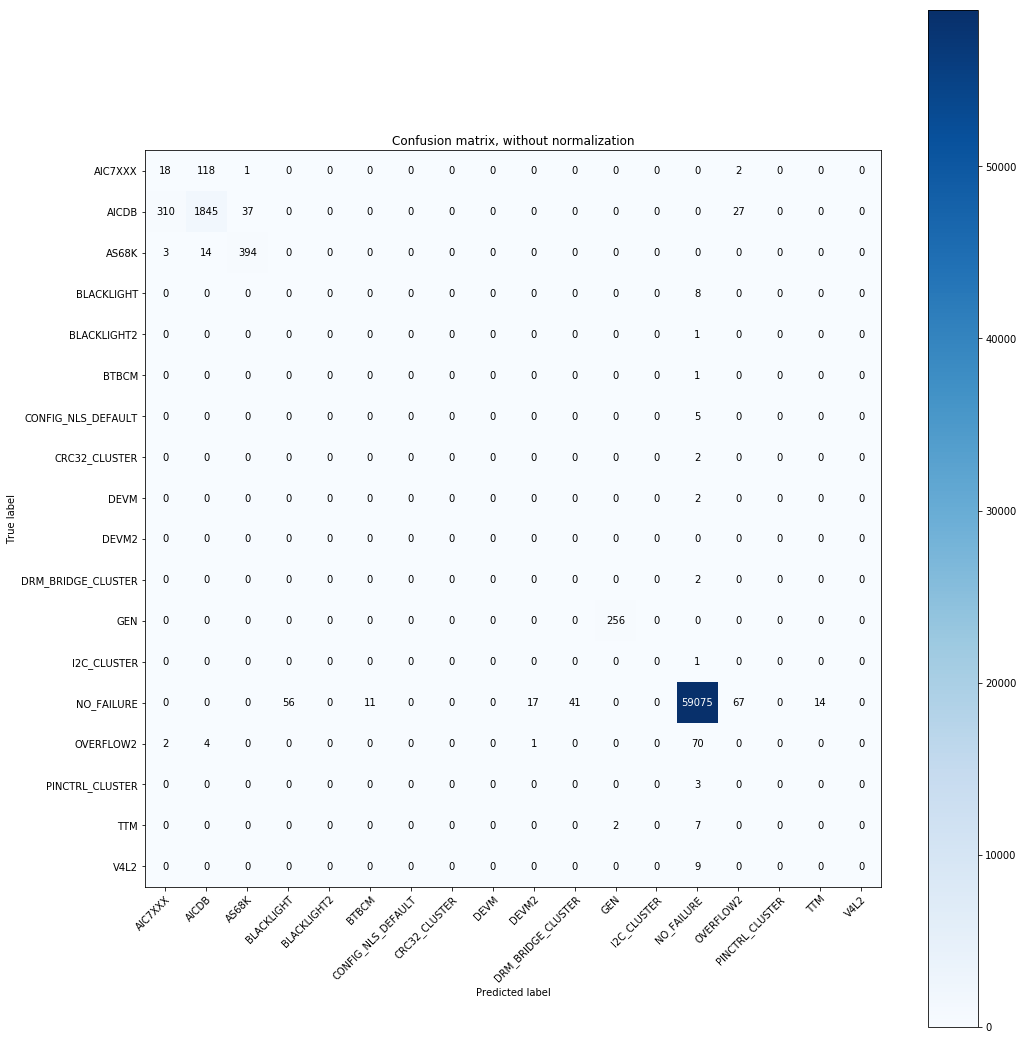

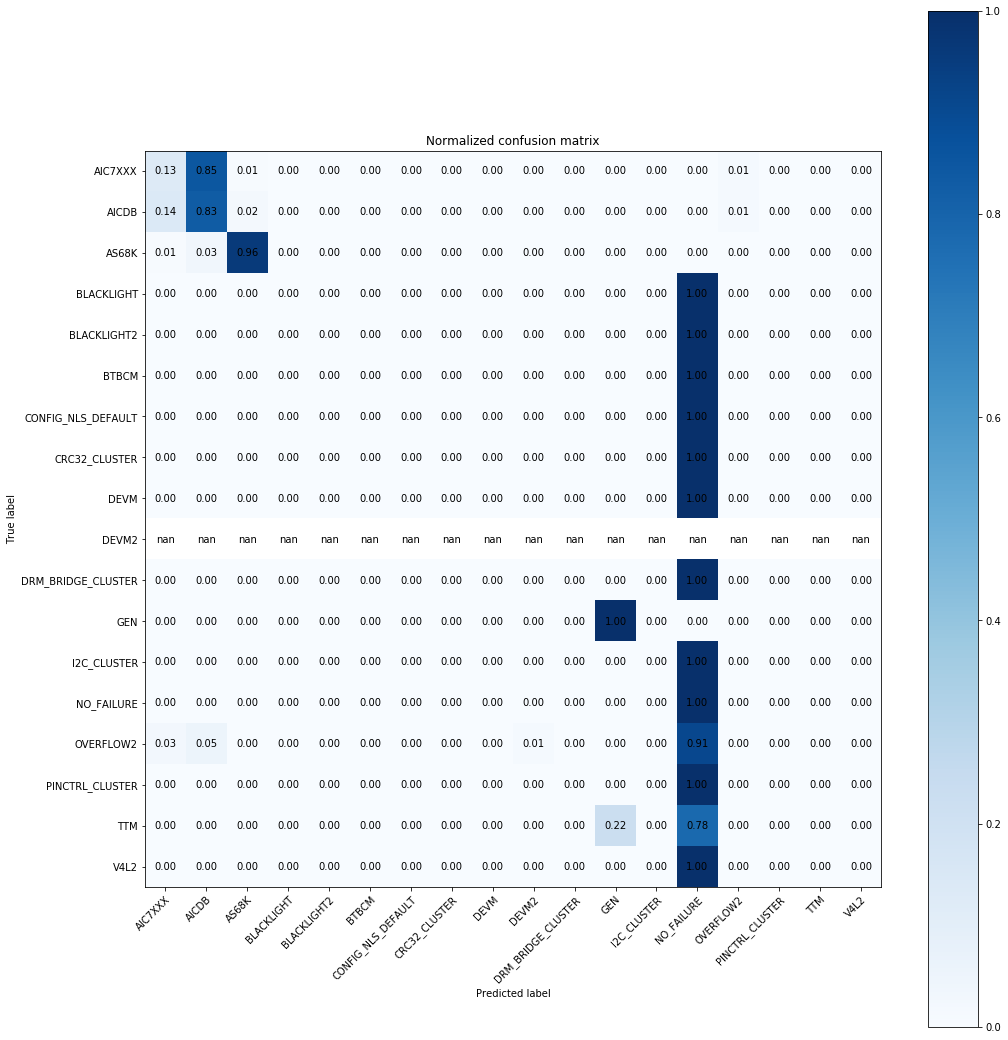

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        #print('Confusion matrix, without normalization')
        pass

    #print(cm)

    fig, ax = plt.subplots(figsize=(15, 15))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test_cluster, y_pred_cluster, classes=np.array(cl_names),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test_cluster, y_pred_cluster, classes=np.array(cl_names), normalize=True,
                      title='Normalized confusion matrix')

plt.show()


In [55]:
from sklearn.metrics import classification_report

print(classification_report(y_test_cluster, y_pred_cluster)) # labels=np.array(cl_names)

              precision    recall  f1-score   support

           0       0.05      0.13      0.08       139
           1       0.93      0.83      0.88      2219
           2       0.91      0.96      0.93       411
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00         5
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         2
          11       0.99      1.00      1.00       256
          12       0.00      0.00      0.00         1
          13       1.00      1.00      1.00     59281
          14       0.00      0.00      0.00        77
          15       0.00      0.00      0.00         3
          16       0.00      0.00      0.00         9
          17       0.00    

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [56]:
np.array(cl_names)

array(['AIC7XXX', 'AICDB', 'AS68K', 'BLACKLIGHT', 'BLACKLIGHT2', 'BTBCM',
       'CONFIG_NLS_DEFAULT', 'CRC32_CLUSTER', 'DEVM', 'DEVM2',
       'DRM_BRIDGE_CLUSTER', 'GEN', 'I2C_CLUSTER', 'NO_FAILURE',
       'OVERFLOW2', 'PINCTRL_CLUSTER', 'TTM', 'V4L2'], dtype='<U18')

In [57]:
#error_patternfirst[ErrorLog.I2C.name]
#rawtuxdata.query("cid == 96730")

In [58]:
rawtuxdata[pattern_name][:20]

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32_CLUSTER,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,GEN,AICDB,AIC7XXX,DRM_BRIDGE_CLUSTER,PINCTRL_CLUSTER,BTBCM,BPFFANCY,DEVM,DEVM2,I2C_CLUSTER
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
5,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
7,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [59]:
for path in all_paths[::-1]: # all_paths[::-1]:
    configs_path = rawtuxdata.query(path + " & compile_success == False")
    clusters_path = []
    for ind, cfg in configs_path.iterrows():  
        cluster_cfg = []
        for err in ErrorLog:
            if(cfg[err.name]):
                cluster_cfg.append(err.name)                
        assert(len(set(cluster_cfg)) == 1)
        clusters_path.append(cluster_cfg[0])
                
    print(path, "=>", set(clusters_path))
    print()
        
    # configs_path['cid'].values
    

AIC79XX_BUILD_FIRMWARE > 0.5 => {'AICDB', 'OVERFLOW2', 'AS68K', 'AIC7XXX'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE > 0.5 => {'AICDB', 'OVERFLOW2', 'AS68K', 'AIC7XXX'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE > 0.5 => {'AS68K'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL > 0.5 & INFINIBAND_ADDR_TRANS > 0.5 & FORTIFY_SOURCE > 0.5 & IPV6 > 1.5 & NEW_LEDS <= 0.5 => {'DEVM2'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL > 0.5 & INFINIBAND_ADDR_TRANS > 0.5 & FORTIFY_SOURCE > 0.5 & IPV6 <= 1.5 & IPV6 > 0.5 & UBSAN_NULL > 0.5 => {'OVERFLOW2'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL > 0.5 & INFINIBAND_ADDR_TRANS > 0.5 & FORTIFY_SOURCE > 0.5 & IPV6 <

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS <= 0.5 & SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH <= 1.5 & SND_PDAUDIOCF <= 1.5 & TYPEC_WCOVE <= 1.5 & CAN_GS_USB > 1.5 & NFC_PN544_I2C <= 0.5 => {'BLACKLIGHT'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS <= 0.5 & SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH <= 1.5 & SND_PDAUDIOCF <= 1.5 & TYPEC_WCOVE <= 1.5 & CAN_GS_USB <= 1.5 & SND_ATMEL_SOC > 1.5 & PCCARD <= 0.5 => {'DEVM'}

AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITI

In [60]:
# rawtuxdata['PM_STD_PARTITION']  

In [61]:
cluster_to_paths = []
for cluster in ErrorLog:
    configs_cluster = rawtuxdata.query(cluster.name + " == True " + "& compile_success == False")
    path_clusters = []
    for ind, cfg in configs_cluster.iterrows():  
        cid = cfg['cid']
        # print(cid)
        # path = find_rule_for_configuration_id(cid)       
        path = find_rule_for_configuration(clf, rawtuxdata.drop(columns=pattern_name).drop(columns=["cid"]).drop(columns=size_methods).drop(columns=compilation_status_column_name).columns, rawtuxdata.query("cid == " + str(cid)).iloc[0])        
        path_clusters.append(path)
                
    print(cluster, "=>", set(path_clusters))
    print()
    cluster_to_paths.append({ cluster : set(path_clusters) })



ErrorLog.BLACKLIGHT => {'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS <= 0.5 & SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH <= 1.5 & SND_PDAUDIOCF <= 1.5 & TYPEC_WCOVE <= 1.5 & CAN_GS_USB > 1.5 & NFC_PN544_I2C <= 0.5', 'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS > 0.5 & PATA_SCH > 0.5 & NLS > 1.5 & USB_F_TCM <= 0.5 & VIDEO_CX88_VP3054 > 0.5 & PANEL_BOOT_MESSAGE <= 4063.5 & BLK_MQ_VIRTIO <= 0.5', 'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XIL

ErrorLog.TTM => {'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS > 0.5 & PATA_SCH <= 0.5 & CAN_EMS_PCI <= 1.5 & INTEL_SOC_PMIC_BXTWC > 1.5 & SATA_QSTOR > 1.5', 'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE > 0.5 & RSI_SDIO > 0.5 & SPEAKUP_SYNTH_BNS <= 0.5 & SND_SOC_INTEL_SKL_NAU88L25_SSM4567_MACH <= 1.5 & SND_PDAUDIOCF <= 1.5 & TYPEC_WCOVE > 1.5 & DRM_NXP_PTN3460 > 1.5', 'AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR > 0.5 & UBSAN_SANITIZE_ALL <= 0.5 & VIDEO_XILINX_TPG > 0.5 & CRC32 > 1.0 & VIDEO_ATOMISP > 0.5 & EDAC_DECODE_MCE

KeyboardInterrupt: 

In [ ]:
#cluster_to_paths

In [ ]:
# AIC79XX_BUILD_FIRMWARE <= 0.5 & AIC7XXX_BUILD_FIRMWARE <= 0.5 & WANXL_BUILD_FIRMWARE <= 0.5 & GENERIC_ALLOCATOR <= 0.5 & DRM_VBOXVIDEO > 1.5
rawtuxdata.query("AIC79XX_BUILD_FIRMWARE > 0.5 & GENERIC_ALLOCATOR <= 0.5 & DRM_VBOXVIDEO > 1.5")[['compile_success', ErrorLog.AICDB.name]]

In [ ]:
# del cluster_errorfirst